# Fundamentals of Software Systems (FSS)
**Software Evolution – Part 02 Assignment**

## Submission Guidelines

To correctly complete this assignment you must:
* Carry out the assignment in a team of 2 to 4 students.
* Carry out the assignment with your team only. You are allowed to discuss solutions with other teams, but each team should come up its own personal solution. A strict plagiarism policy is going to be applied to all the artifacts submitted for evaluation.
* As your submission, upload the filled Jupyter Notebook (including outputs) together with the d3 visualization web pages (i.e. upload everything you downloaded including the filled Jupyter Notebook plus your `output.json`)
* The files must be uploaded to OLAT as a single ZIP (`.zip`) file by Dec 15, 2025 @ 23:55.


## Group Members
* Firstname, Lastname, Immatrikulation Number
* Charlotte Model, 21-717-731
* Dominic Tobler, 21-705-223
* Remo Wiget, 21-742-655

## Task Context

In this assigment we will be analyzing the _elasticsearch_ project. All following tasks should be done with the subset of commits from tag `v0.90.0` to tag `v1.1.0.RC1`.

In [22]:
from enum import Enum
from warnings import catch_warnings
import matplotlib.pyplot as plt
import numpy as np
import pydriller

class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"


elastic_search_repo = pydriller.Repository("./elasticsearch",
                            from_tag="v0.90.0",
                            to_tag="v1.0.0.RC1")
total_number_of_commits = 0
for commit in elastic_search_repo.traverse_commits():
    total_number_of_commits += 1

print(total_number_of_commits)

1934


## Task 1: Author analysis

In the following, please consider only `java` files.

The first task is to get an overview of the author ownership of the _elasticsearch_ project. In particular, we want to understand who are the main authors in the system between the two considered tags, the authors distribution among files and the files distribution among authors. To this aim, perform the following:
- create a dictionary (or a list of tuples) with the pairs author => number of modified files
- create a dictionary (or a list of tuples) with the pairs file => number of authors who modified the file
- visualize the distribution of authors among files: the visualization should have on the x axis the number of authors per file (from 1 to max), and on the y axis the number of files with the given number of authors (so for example the first bar represent the number of files with single author)
- visualize the distribution of files among authors: the visualization should have on the x axis the number of files per author (from 1 to max), and on the y axis the number of authors that own the given number of files (so for example the first bar represent the minor contributors, i.e., the number of authors who own 1 file)

Comment the two distribution visualizations.



Now, let's look at the following 3 packages in more details:
1. `src/main/java/org/elasticsearch/search`
2. `src/main/java/org/elasticsearch/index`
3. `src/main/java/org/elasticsearch/action`

Create a function that, given the path of a package and a modification type (see class Modification above), returns a dictionary of authors => number, where the number counts the total lines added or removed or added+removed or added-removed (depending on the given Modification parameter), for the given package. To compute the value at the package level, you should aggregate the data per file.

Using the function defined above, visualize the author contributions (lines added + lines removed). The visualization should have the author on the x axis, and the total lines on the y axis. Sort the visualization in decreasing amount of contributions, i.e., the main author should be the first.

Compare the visualization for the 3 packages and comment.

In [38]:
from collections import defaultdict
from tqdm import tqdm

progress = tqdm(unit="commit", total=total_number_of_commits)

authorToModifiedFiles = defaultdict(list)
fileToAuthors = defaultdict(list)
errors = 0

for commit in elastic_search_repo.traverse_commits():
    try:
        commitAuthor = commit.author.name
        files = commit.modified_files
        for file in files:
            fileName = file.filename
            authorToModifiedFiles[commitAuthor].append(fileName)
            fileToAuthors[fileName].append(commitAuthor)
    except ValueError:
        errors += 1
    finally:
        progress.update(1)

100%|█████████▉| 1931/1934 [00:29<00:00, 68.26commit/s]

In [61]:
authorToModifiedFilesNum = defaultdict(int)
fileToAuthorsNum = defaultdict(int)

for author, files in authorToModifiedFiles.items():
    authorToModifiedFilesNum[author] = len(set(files))

for file, authors in fileToAuthors.items():
    fileToAuthorsNum[file] = len(set(authors))

[   0 1687 1376  631  294  130   48   32   16    8    0    0    1    1
    0    0    1]


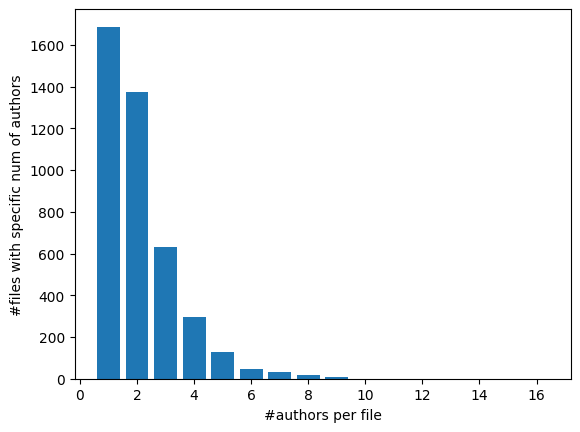

In [92]:
# Visualization
y_counts = np.bincount(list(fileToAuthorsNum.values()))
x_counts = np.arange(len(y_counts))

plt.bar(x_counts[1:], y_counts[1:])       # make plot start at 1
plt.xlabel("#authors per file")
plt.ylabel("#files with specific num of authors")
plt.show()


This plot visualizes how distributed the file authorship is across the elastic search library. We see that many files have few authors, while few files have a lot of authors.
From a software engineering perspective, we would expect a file that is maintained by a lower number of authors to yield a better quality due to the sense of responsibility. When a lot of authors work on a file, this responsibility gets diluted, so nobody might feel the need to refactor the code to maintain a certain code quality.
On the other hand, one could argue, that a single author editing a file points to knowledge about this specific piece of coe being concentrated in the hands of one person, leading to problems when this person leaves the project.

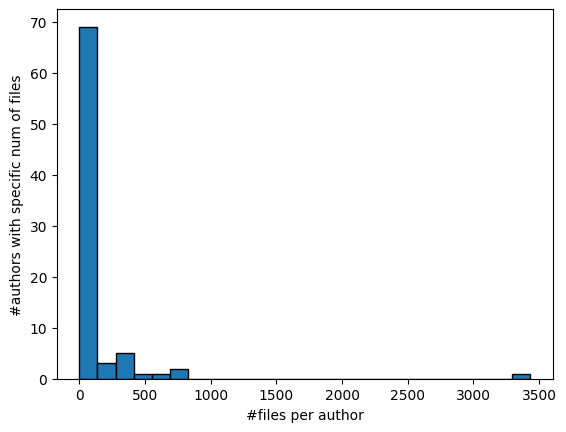

In [101]:
hist, bin_edges = np.histogram(list(authorToModifiedFilesNum.values()), bins=25)

plt.bar(
    bin_edges[:-1],
    hist,
    width=np.diff(bin_edges),  # widths of bars
    align='edge',
    edgecolor='black')
plt.xlabel("#files per author")
plt.ylabel("#authors with specific num of files")
plt.show()


This visualization shows the distribution of contributions to the elastic search codebase.
It is observable that most authors only edited one file, while some authors contributed a lot more.
From a software engineering perspective, we would expect it to  be desirable, having authors that know about the project and contribute multiple times. Those authors commiting a lot, being responsible for a high proportion of contributions, are important for the project, concentrating a lot of knowledge in specific authors. Then again, the amount of concentration in this project is high, with one author editing over 3'000 files. Would this person leave, a lot of project specific knowledge would be lost. This can impose relevant risks for the long-term survival of the project.


## Task 2: Knowledge loss

We now want to analyze the knowledge loss when the main contributor of the analyzed project would leave. For this we will use the circle packaging layout introduced in the "Code as a Crime Scene" book. This assignment includes the necessary `knowledge_loss.html` file as well as the `d3` folder for all dependencies. You task is to create the `output.json` file according to the specification below. This file can then be visualized with the files provided.

For showing the visualization, once you have the output as `output.json` you should
* make sure to have the `knowledge_loss.html` file in the same folder
* start a local HTTP server in the same folder (e.g. with python `python3 -m http.server`) to serve the html file (necessary for d3 to work)
* open the served `knowledge_loss.html` and look at the visualization

For the package you identify as the worst in terms of knowledge loss, investigate the author contributions using the function defined in the previous exercise and comment how the situation is, e.g. how big the gap between the main author and the second biggest contributor for the selected package is.

### Output Format for Visualization

* `root` is always the root of the tree
* `size` should be the total number of lines of contribution
* `weight` can be set to the same as `size`
* `ownership` should be set to the percentage of contributions from the main author (e.g. 0.98 for 98% if contributions coming from the main author)

```
{
  "name": "root",
  "children": [
    {
      "name": "test",
      "children": [
        {
          "name": "benchmarking",
          "children": [
            {
              "author_color": "red",
              "size": "4005",
              "name": "t6726-patmat-analysis.scala",
              "weight": 1.0,
              "ownership": 0.9,
              "children": []
            },
            {
              "author_color": "red",
              "size": "55",
              "name": "TreeSetIterator.scala",
              "weight": 0.88,
              "ownership": 0.9,
              "children": []
            }
          ]
        }
      ]
    }
  ]
}
```

### JSON Export

For exporting the data to JSON you can use the following snippet:

```
import json

with open("output.json", "w") as file:
    json.dump(tree, file, indent=4)
```

## Task 3: Code Churn Analysis

The third and last task is to analyze the code churn of the _elasticsearch_ project. For this analysis we look at the code churn, meaning the daily change in the total number of lines of the project. Visualize the code churn over time bucketing the data by day. Remember that you'll need to interpolate the data for days when there are no commits. Chose an interpolation strategy and justify it.

Look at the churn trend over time and identify two outliers. For each of them:
- identify if it was caused by a single or multiple commits (since you are bucketing the data by day)
- find the hash of the involved commit(s)
- find the involved files
- look at the actual diff

Based on the above, discuss if the outlier is a false positive or should be a reason for concern.